In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
plt.rcParams["svg.fonttype"] = "none"  # Ensures the text is not converted to paths
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
file_name = "Analysis/Exploratory/revision/curated/mono_disomes_analysis_as_TE_alternative/full_dataset.tsv"
full_df = pd.read_csv(file_name, sep="\t")
naive_smoops = set(full_df[full_df["smoops_naive"]]["gene_id"])
print(len(naive_smoops))

449


In [3]:
smoops_w_all_feat_pred = pd.read_csv('Analysis/Exploratory/revision/smoops_stress/data/temp_files/smoops_transcripts_all_features_collapsed_length_subset_with_predictions.tsv', sep='\t')
smoops_w_all_feat_pred = smoops_w_all_feat_pred[(smoops_w_all_feat_pred["nostress_smoops"]) | (smoops_w_all_feat_pred["nostress_control"])]
smoops_w_all_feat_pred = smoops_w_all_feat_pred[["transcript_id", "nostress_smoops", "nostress_control",  smoops_w_all_feat_pred.columns[-1]]]
smoops_w_seq_pred = pd.read_csv('Analysis/Exploratory/revision/smoops_stress/data/temp_files/stress_smoops_transcripts_seq_collapsed_length_subset_with_predictions.tsv', sep='\t')
smoops_w_seq_pred = smoops_w_seq_pred[(smoops_w_seq_pred["nostress_smoops"]) | (smoops_w_seq_pred["nostress_control"])]
smoops_w_seq_pred = smoops_w_seq_pred[["transcript_id", "nostress_smoops", "nostress_control",  smoops_w_seq_pred.columns[-1]]]
smoops_w_control_pred = pd.read_csv('Analysis/Exploratory/revision/smoops_stress/data/temp_files/stress_smoops_transcripts_seq_collapsed_length_subset_with_control_predictions.tsv', sep='\t')
smoops_w_control_pred = smoops_w_control_pred[(smoops_w_control_pred["nostress_smoops"]) | (smoops_w_control_pred["nostress_control"])]
smoops_w_control_pred = smoops_w_control_pred[["transcript_id", "nostress_smoops", "nostress_control",  smoops_w_control_pred.columns[-1]]]
smoops_combined = pd.merge(smoops_w_all_feat_pred, smoops_w_seq_pred, on=["transcript_id", "nostress_smoops", "nostress_control"])
smoops_combined = pd.merge(smoops_combined, smoops_w_control_pred, on=["transcript_id", "nostress_smoops", "nostress_control"])
smoops_combined["Class"] = smoops_combined["nostress_smoops"].astype(int)
smoops_combined.rename(columns={"Naive smOOPs Model All Features smOOPs Predicted Probability": "All Features Model",
                                         "Naive smOOPs Model smOOPs Probability": "Sequence Only Model",
                                         "Control smOOPs Model smOOPs Predicted Probability": "Length Control Model"}, inplace=True)
smoops_combined["Class"].value_counts()

Class
0    3942
1     562
Name: count, dtype: int64

In [4]:
transcript_data = []

with open('/ceph/hpc/home/novljanj/data_storage/genomes/genome_m39/gencode.vM27.chr_patch_hapl_scaff.annotation.gtf', 'r') as gtf_file:
    for line in gtf_file:
        if line.startswith('#'):
            continue

        columns = line.strip().split('\t')
        attributes = columns[8]

        if 'transcript_id' in attributes:
            transcript_id = [field for field in attributes.split(';') if 'transcript_id' in field][0]
            transcript_id = transcript_id.split('"')[1]
            gene_id = [field for field in attributes.split(';') if 'gene_id' in field][0]
            gene_id = gene_id.split('"')[1]

            transcript_data.append(columns[:7] + [transcript_id] + [gene_id])

column_names = ['seqname', 'source', 'feature', 'start', 'end', 'score', "strand", 'transcript_id', 'gene_id']

annotation = pd.DataFrame(transcript_data, columns=column_names)
annotation['start'] = annotation['start'].astype(int) - 1
annotation = annotation[["transcript_id", "gene_id"]]
annotation.drop_duplicates(subset=["transcript_id"], inplace=True)
annotation

,transcript_id,gene_id
0,ENSMUST00000193812.2,ENSMUSG00000102693.2
2,ENSMUST00000082908.3,ENSMUSG00000064842.3
4,ENSMUST00000162897.2,ENSMUSG00000051951.6
7,ENSMUST00000159265.2,ENSMUSG00000051951.6
10,ENSMUST00000070533.5,ENSMUSG00000051951.6
...,...,...
1814209,ENSMUST00000180208.2,ENSMUSG00000095475.2
1814219,ENSMUST00000178327.2,ENSMUSG00000094855.2
1814229,ENSMUST00000178569.2,ENSMUSG00000095019.2
1814233,ENSMUST00000179505.8,ENSMUSG00000095041.8


In [5]:
smoops_combined = smoops_combined.merge(annotation, on="transcript_id", how="left")

In [6]:
smoops_combined["gene_id"] = smoops_combined["gene_id"].str.split(".").str[0]
smoops_combined

,transcript_id,nostress_smoops,nostress_control,All Features Model,Sequence Only Model,Length Control Model,Class,gene_id
0,ENSMUST00020183322.1,False,True,0.063052,0.372587,0.307033,0,ENSMUSG00002076173
1,ENSMUST00020183512.1,False,True,0.082785,0.390298,0.306932,0,ENSMUSG00002075764
2,ENSMUST00000198802.3,False,True,0.226046,0.403263,0.305857,0,ENSMUSG00000106366
3,ENSMUST00000082397.1,False,True,0.129090,0.406756,0.309013,0,ENSMUSG00000064346
4,ENSMUST00000082503.4,False,True,0.304272,0.403723,0.307848,0,ENSMUSG00000064437
...,...,...,...,...,...,...,...,...
4499,ENSMUST00000036579.14,True,False,0.806201,0.996920,0.994669,1,ENSMUSG00000020220
4500,ENSMUST00000097822.10,True,False,0.999606,0.999426,0.994806,1,ENSMUSG00000066036
4501,ENSMUST00000068792.13,True,False,0.985302,0.957314,0.994815,1,ENSMUSG00000055296
4502,ENSMUST00000214357.2,True,False,0.996865,0.999240,0.995232,1,ENSMUSG00000034275


Class
0    3942
1     562
Name: count, dtype: int64


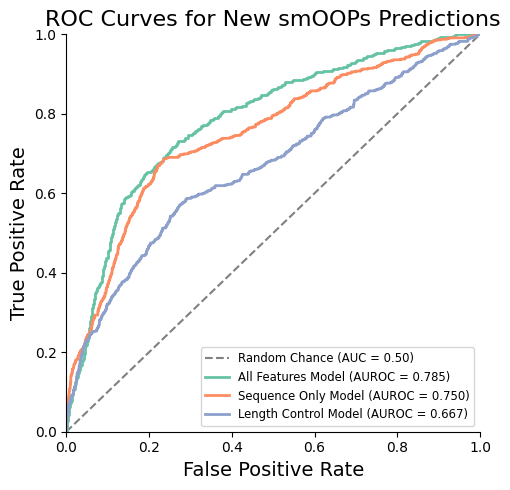

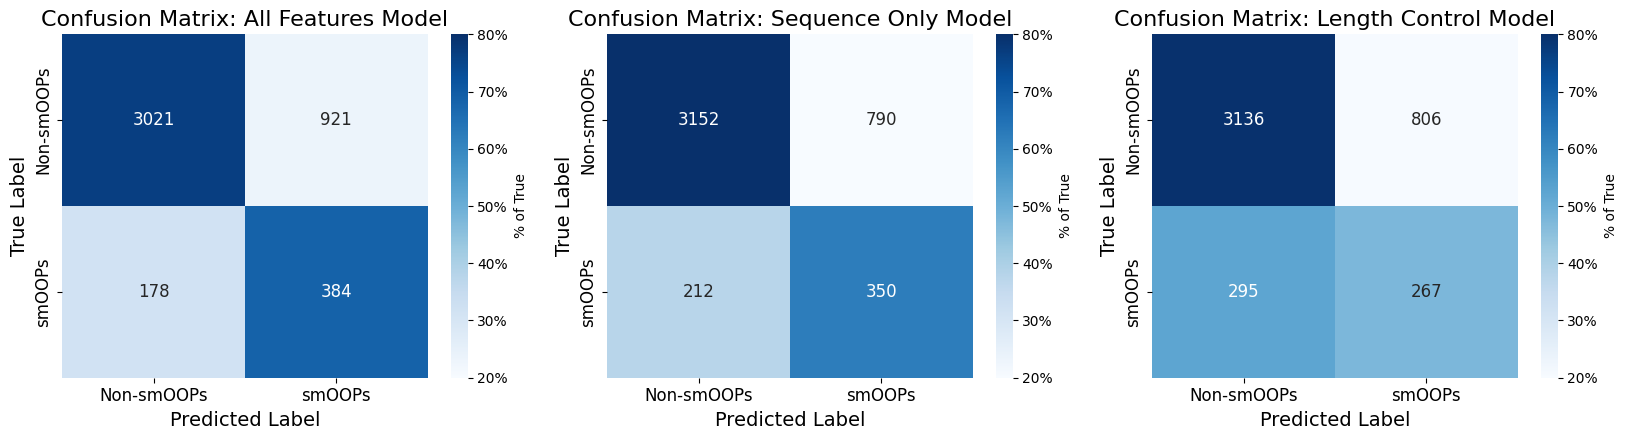

/tmp/ipykernel_1061449/4094455149.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1061449/4094455149.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
/tmp/ipykernel_1061449/4094455149.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1061449/4094455149.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
/tmp/ipykernel_1061449/4094455149.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x

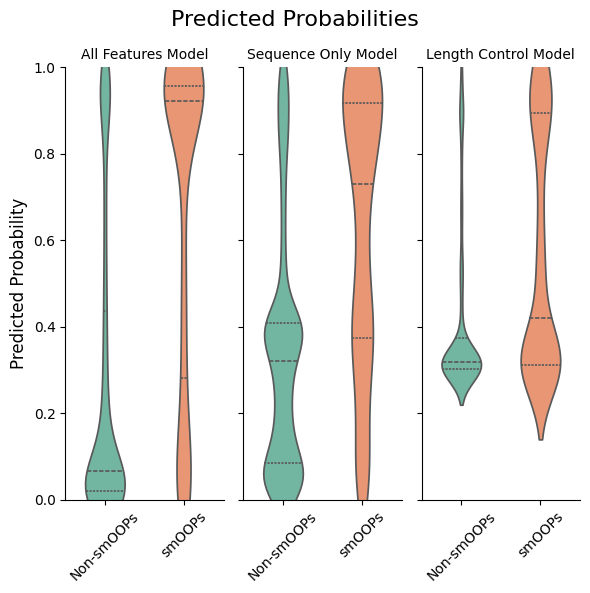

In [7]:
def plot_roc_curves(df, y_col, prob_cols, figsize=(8, 6)):
    print(df[y_col].value_counts())
    """
    Plots ROC curves for multiple prediction‐probability columns against a binary true label,
    using the Set2 color palette, and displays the figure.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = sns.color_palette("Set2", n_colors=len(prob_cols))
    
    ax.plot(
        [0, 1], [0, 1],
        color='gray',
        linestyle='--',
        label='Random Chance (AUC = 0.50)'
    )

    y_true = df[y_col]

    for col, color in zip(prob_cols, colors):
        y_score = df[col]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)
        ax.plot(
            fpr, tpr,
            lw=2,
            color=color,
            label=f"{col} (AUROC = {roc_auc:.3f})"
        )

    ax.set_title("ROC Curves for New smOOPs Predictions", fontsize=16)
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.legend(loc="lower right", fontsize='small')
    plt.tight_layout()
    sns.despine()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.show()


def plot_confusion_matrices(df, y_col, pred_cols, labels=None, figsize=(12, 4)):
    """
    Plots confusion matrices for multiple prediction columns against a binary true label.
    Each matrix is normalized by the true label (rows), colored by percentage, and annotated
    with raw counts and % of true-label row.
    """

    class_names = {0: "Non‑smOOPs", 1: "smOOPs"}

    n_models = len(pred_cols)
    fig, axes = plt.subplots(
        1, n_models,
        figsize=(figsize[0] * n_models, figsize[1]),
        squeeze=False
    )
    colors = sns.color_palette("Set2", n_colors=n_models)
    
    y_true = df[y_col]
    if labels is None:
        labels = sorted(df[y_col].unique())

    tick_labels = [class_names.get(l, str(l)) for l in labels]

    for i, (col, color) in enumerate(zip(pred_cols, colors)):
        y_pred = df[col] > 0.5
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100.0

        annot = [
            [f"{cm[r, c]}"
             for c in range(cm.shape[1])]
            for r in range(cm.shape[0])
        ]

        ax = axes[0, i]
        sns.heatmap(
            cm_pct,
            annot=annot,
            fmt="",                
            cmap="Blues",
            cbar=True,
            cbar_kws={
                "label": "% of True", 
                "format": "%.0f%%"    
            },
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            ax=ax,
            annot_kws={"size": 12},
            vmin=20,
            vmax=80,
        )

        ax.set_title(f"Confusion Matrix: {col}", fontsize=16)
        ax.set_xlabel("Predicted Label", fontsize=14)
        ax.set_ylabel("True Label", fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=12)

    plt.tight_layout()
    plt.show()


def plot_probability_boxplots(df, y_col, pred_cols, labels=None, figsize=(12, 4)):
    """
    Plots boxplots of predicted probabilities for multiple models,
    separated by the true binary label (Non‑smOOPs vs smOOPs).
    """

    class_names = {0: "Non‑smOOPs", 1: "smOOPs"}

    n_models = len(pred_cols)
    fig, axes = plt.subplots(
        1, n_models,
        figsize=(figsize[0] * n_models, figsize[1]),
        sharey=True,      
        squeeze=False
    )
    fig.subplots_adjust(top=0.85)

    fig.suptitle("Predicted Probabilities", fontsize=16)

    if labels is None:
        labels = sorted(df[y_col].unique())
    tick_labels = [class_names.get(l, str(l)) for l in labels]

    for i, col in enumerate(pred_cols):
        ax = axes[0, i]
        plot_df = df[[y_col, col]].copy()
        plot_df['True Label'] = plot_df[y_col].map(class_names)
        
        sns.violinplot(
            x='True Label',
            y=col,
            data=plot_df,
            ax=ax,
            palette="Set2",
            width = 0.5,
            inner="quartile",
        )

        ax.set_title(col, fontsize=10)
        ax.set_xlabel("")  
        ax.set_ylabel("Predicted Probability" if i == 0 else "", fontsize=12) 

        ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
        ax.set_ylim(0, 1)      
        sns.despine()

    plt.tight_layout()
    plt.show()



probability_columns = [
    "All Features Model",
    "Sequence Only Model",
    "Length Control Model"
]

plot_roc_curves(
    smoops_combined,
    y_col="Class",
    prob_cols=probability_columns,
    figsize=(5, 5)
)

plot_confusion_matrices(
    smoops_combined,
    y_col="Class",
    pred_cols=probability_columns,
    figsize=(5.5, 4.5)
)

plot_probability_boxplots(
    smoops_combined,
    y_col="Class",
    pred_cols=probability_columns,
    figsize=(2, 6)
)